In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [148]:
# params for dataset loading
# IMPT: remember to change ds_order (dataset order) accordingly
dataset_paths = ['./datasets/fm_1.csv', './datasets/wifi_2_1.csv', './datasets/4g_2.csv']
ds_order = ['FM', 'Wifi', '4G']
record_tags = {k : i for i, k in enumerate(np.unique(sorted(ds_order)))}

print(record_tags)

# do consistency checks
# stop execution if dataset_paths and ds_order are not of equal length
assert (len(dataset_paths) == len(ds_order)), 'Length of dataset_paths and ds_order are mismatched.'
# check if all ds_order tags are in record_tags
# assert all(item in list(record_tags.keys()) for item in ds_order), 'Not all ds_order tags exist in record_tags'

{'4G': 0, 'FM': 1, 'Wifi': 2}


In [146]:
# load the dataset(s)


# load dataset information
specs = []
datasets = []

for path in dataset_paths:
    df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
    df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')
    
    specs.append(df_spec)

    # load data
    df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])
    df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
    df['I'] = df['I'].astype('float')
    
    datasets.append(df)

In [147]:
np.unique(ds_order)

array(['4G', 'FM', 'Wifi'], dtype='<U4')

In [3]:
specs[2]

,info
SamplingFrequency,28000000
NumberSamples,1024
NumberRecords,3553


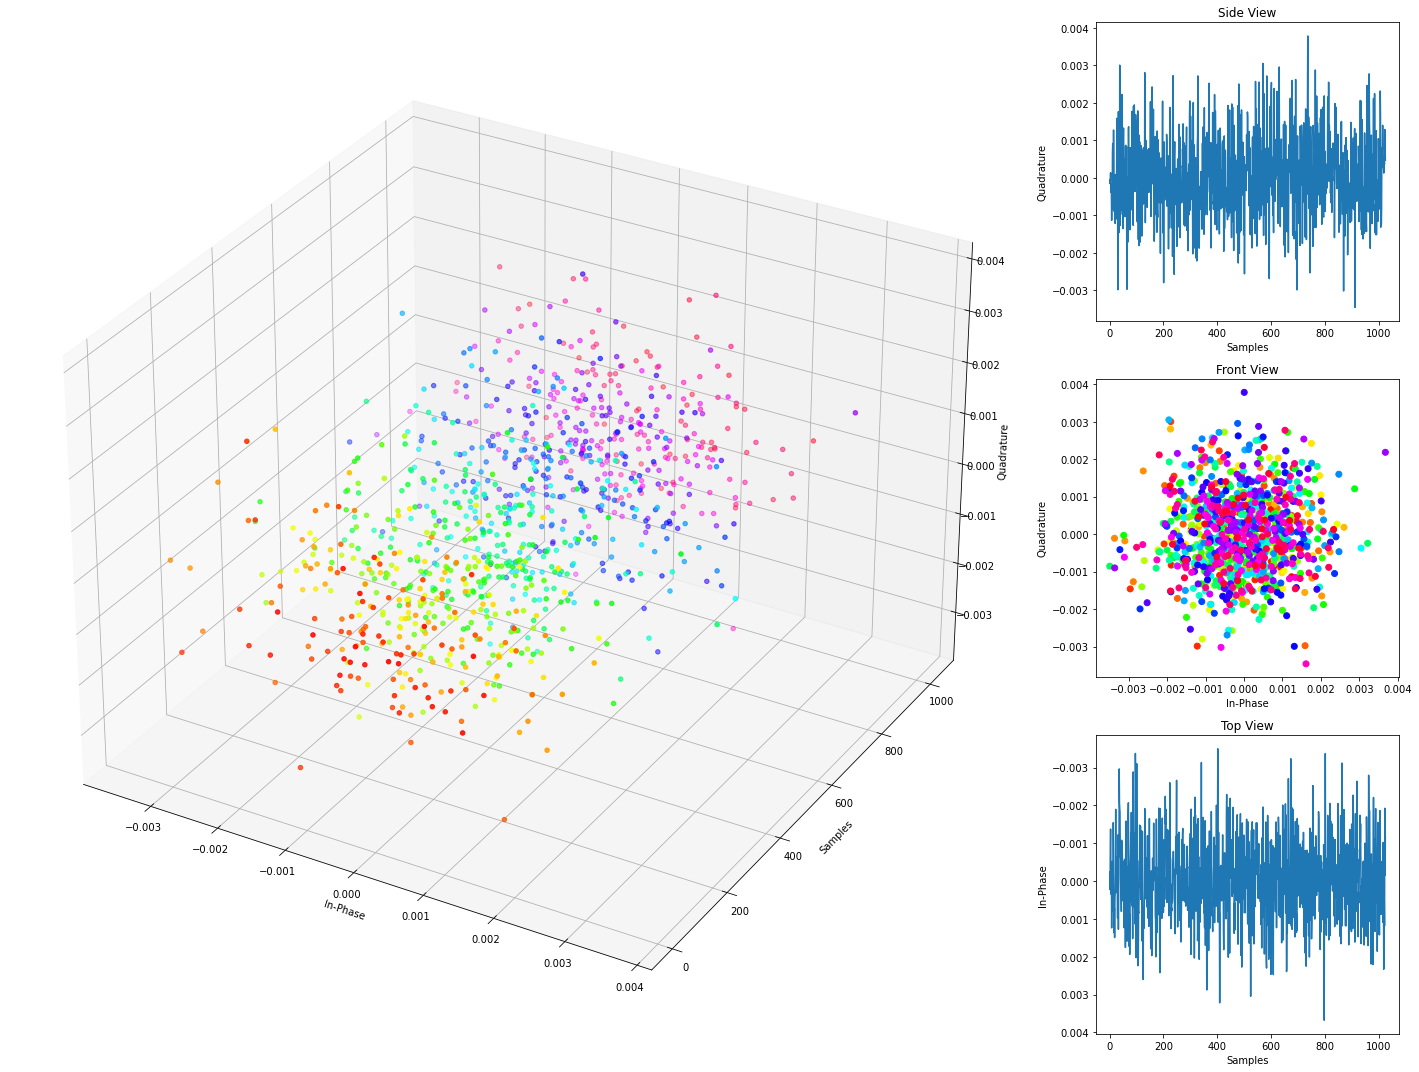

In [4]:
# plot a record sample
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 4)
ax = fig.add_subplot(gs[:3, :3], projection='3d')

x = datasets[2].iloc[:specs[2].loc['NumberSamples']['info']]['I'].values
z = datasets[2].iloc[:specs[2].loc['NumberSamples']['info']]['Q'].values
y = np.arange(1, specs[2].loc['NumberSamples']['info']+1)

ax.scatter(x, y, z, c=y, cmap='hsv')
ax.set_xlabel('In-Phase')
ax.set_ylabel('Samples')
ax.set_zlabel('Quadrature')

ax1 = fig.add_subplot(gs[0, 3])
ax1.plot(y, z)
ax1.set_xlabel('Samples')
ax1.set_ylabel('Quadrature')
ax1.set_title('Side View')

ax2 = fig.add_subplot(gs[1, 3])
ax2.scatter(x, z, c=y, cmap='hsv')
ax2.set_xlabel('In-Phase')
ax2.set_ylabel('Quadrature')
ax2.set_title('Front View')

ax3 = fig.add_subplot(gs[2, 3])
ax3.plot(y, x)
ax3.set_xlabel('Samples')
ax3.set_ylabel('In-Phase')
ax3.set_title('Top View')
ax3.invert_yaxis()


plt.tight_layout()
plt.show()

In [141]:
# split dataset(s) into records, extract test dataset
train = []
test = []

# number of test records to extract
ntest = 50

print(f'Type\tTotal Records\tSamples/Record')
for i in range(len(datasets)):
    nrecords = specs[i].loc['NumberRecords']['info']
    nsamples = specs[i].loc['NumberSamples']['info']

    # sanity check
    print(f'{ds_order[i]:<7}\t{nrecords:<7}\t\t{nsamples:<7}')

    # loop through dataset to split 
    for j in range(nrecords):
        # extract sample length worth of samples for each record, then transpose for easier access later
        record = datasets[i].iloc[(nsamples * j):(nsamples * (j+1))].values.T
        
        # extract first <ntest> records
        if j < ntest:
            test.append([ds_order[i], record_tags[ds_order[i]], record])
        else:
            train.append([ds_order[i], record_tags[ds_order[i]], record])

# convert lists into dataframes for later use, randomise
df_train = pd.DataFrame(train, columns=['signal_type', 'tag', 'record']).sample(frac=1)
df_test = pd.DataFrame(test, columns=['signal_type', 'tag', 'record']).sample(frac=1)

# print dataset statistics
print(f'\n{"Stats":^13}')
print(f'Dataset\tLength')
print(f'Train\t{df_train.shape[0]:<5}')
print(f'Test\t{df_test.shape[0]:<5}')

Type	Total Records	Samples/Record
FM     	5023   		1024   
Wifi   	92     		417    
4G     	3553   		1024   

    Stats    
Dataset	Length
Train	8518 
Test	150  


In [142]:
df_train.head(3)

,signal_type,tag,record
7050,4G,2,"[[-0.01724796, -0.02206355, -0.02300964, -0.00..."
5644,4G,2,"[[-0.00069992, 0.00060565, 0.00036145, 0.00158..."
3999,FM,0,"[[-0.00086733, -0.00062088, -0.00035313, 0.000..."


In [52]:
# ensure no data gets corrupted in processing
I_check = sum(df_records['record'].iloc[0][0] == df.iloc[:df_spec.loc['NumberSamples']['info']]['I'].values) == df_spec.loc['NumberSamples']['info']
Q_check = sum(df_records['record'].iloc[0][1] == df.iloc[:df_spec.loc['NumberSamples']['info']]['Q'].values) == df_spec.loc['NumberSamples']['info']

print(f'I check: {I_check} | Q check: {Q_check}')

I check: True | Q check: True
